In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [167]:
sess_name='e13_26m1_210913'#"e15_13f1_220117"#
data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913' #"/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"#
py_data_dir = os.path.join(data_dir_full,"py_data")
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)

In [168]:
data_dir_full = data_dir_full
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [169]:
fr_filtered = copy.copy(fr.query("(speed>=1.)"))
# fr_filtered[cell_cols_pyr] = fr_filtered[cell_cols_pyr] / dt
fr_mean_trial_type = fr_filtered.groupby(['visitedArm','trial']).mean()[cell_cols_pyr]
fr_mean_all = fr_filtered.groupby('trial').mean()[cell_cols_pyr]

fr_to_be_nmfed = {'0':fr_mean_trial_type.loc[0],'1':fr_mean_trial_type.loc[1],'both':fr_mean_all}

In [6]:
# reload(na)
# X_to_be_nmfed = {}
# pyr_mask_d = {}
# for k,val in fr_to_be_nmfed.items():
#     X_to_be_nmfed[k],pyr_mask_d[k]= na.normalize(val.values.T)

# pyr_mask_joint = np.all(np.stack(list(pyr_mask_d.values()),axis=0),axis=0)

/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:51: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant


ValueError: too many values to unpack (expected 2)

In [181]:
reload(na)
n_compo = 5
W_d, W_sorted_d,W_inds_d, factor_assignment_d, H_sorted_d, X_sorted_d, X_recon_sorted_d, pyr_mask_joint,non_na_original_ind_joint = na.nmf_multiple_fr_df_once(fr_to_be_nmfed,n_compo)



/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:52: RuntimeWarning: invalid value encountered in true_divide
  non_na_original_ind = np.nonzero(pyr_mask)[0]


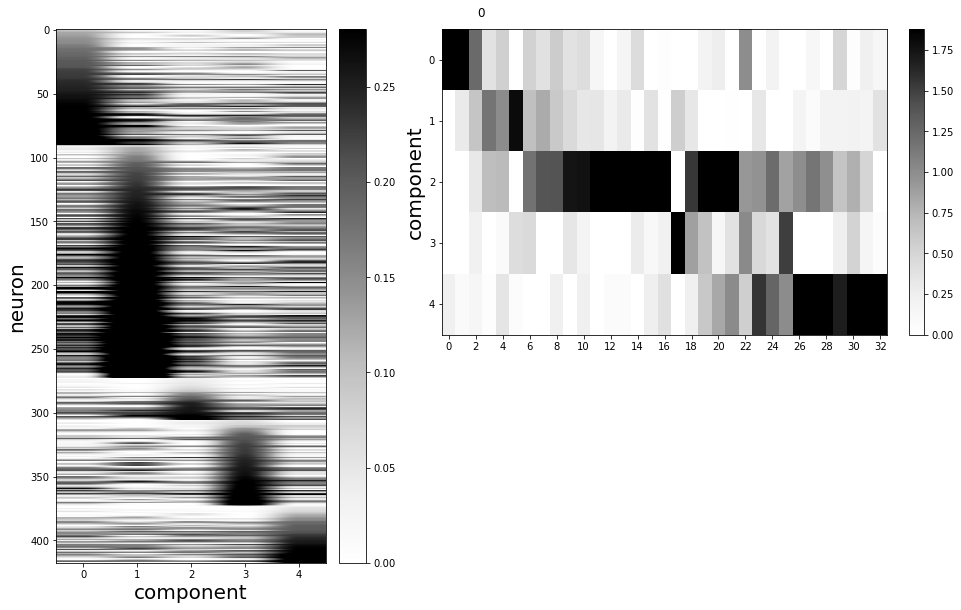

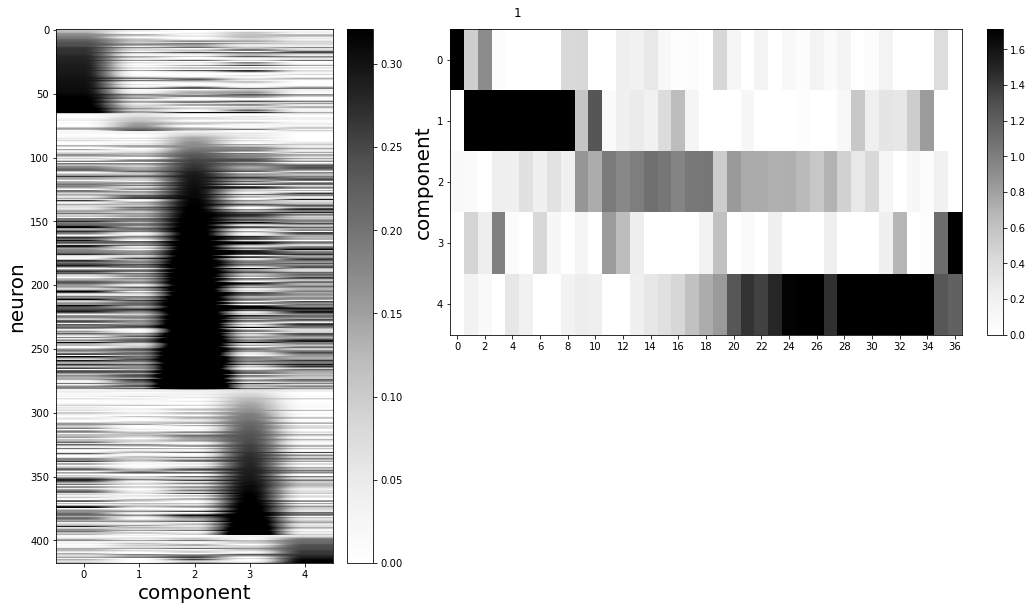

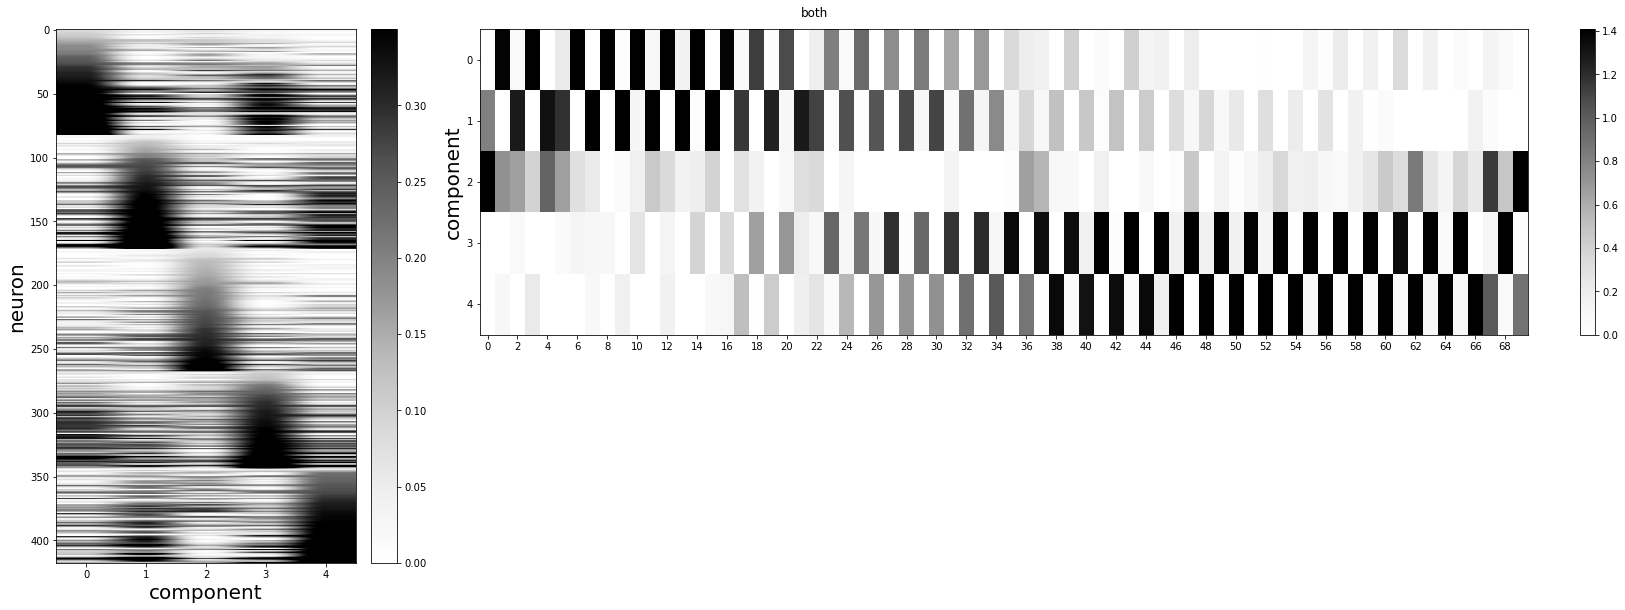

In [182]:
reload(nmfp)
for data_key in W_sorted_d.keys():
    fig,axd=nmfp.plot_wh(W_sorted_d[data_key],H_sorted_d[data_key])
    fig.suptitle(data_key)

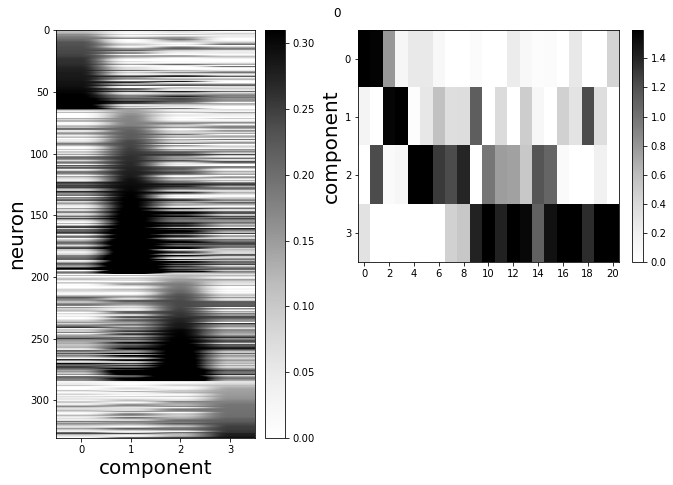

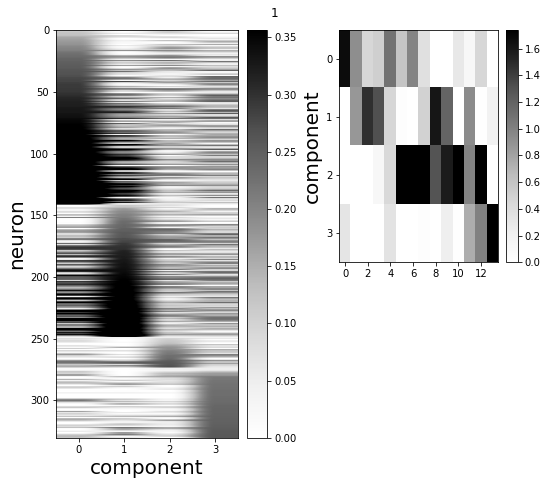

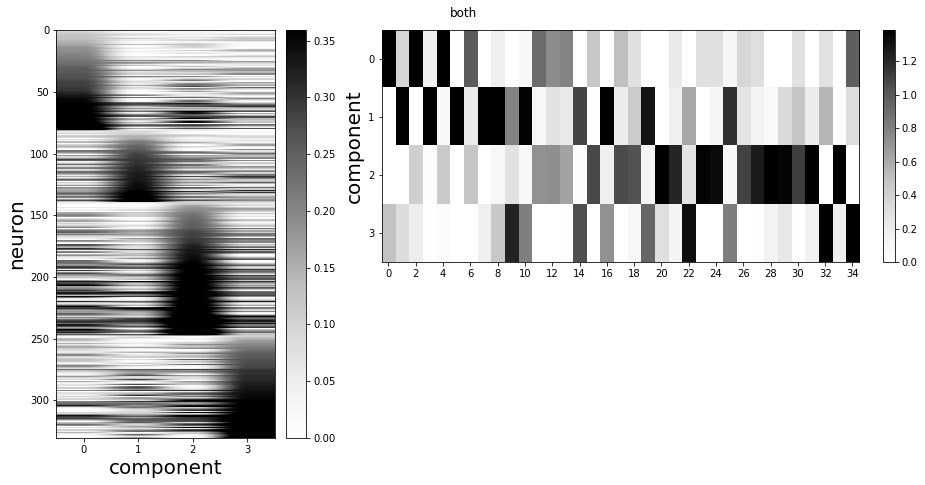

In [514]:
reload(nmfp)
for data_key in W_sorted_d.keys():
    fig,axd=nmfp.plot_wh(W_sorted_d[data_key],H_sorted_d[data_key])
    fig.suptitle(data_key)

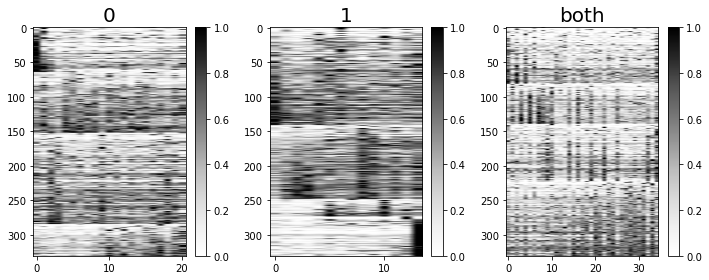

In [13]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
for ii,k in enumerate(X_sorted_d.keys()):
    fig,ax=nmfp.plot_X_sorted(X_sorted_d[k],fig=fig,ax=axs[ii],spacing=10)
    ax.set_title(k)
plt.tight_layout()

In [14]:
from scipy.ndimage import gaussian_filter1d

In [15]:
W_normed_rowsum = W_d[k] /  W_d[k].sum(axis=1,keepdims=True)

(array([64., 34., 72., 69., 53., 19.,  9.,  3.,  5.,  3.]),
 array([0.        , 0.09320716, 0.18641431, 0.27962147, 0.37282862,
        0.46603578, 0.55924293, 0.65245009, 0.74565724, 0.8388644 ,
        0.93207155]),
 <BarContainer object of 10 artists>)

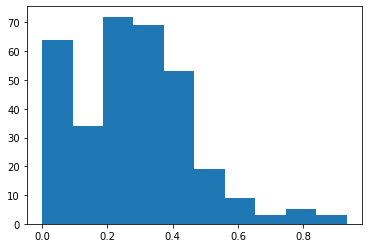

In [16]:
plt.hist(W_normed_rowsum[:,-1] )

In [124]:
W_normed_rowsum[sample_inds_within_W_sorted[0]]

array([0.6142227 , 0.20461116, 0.18116615, 0.        ])

In [138]:
reload(nmfp)

<module 'nmf_plot' from '/mnt/home/szheng/projects/nmf_analysis/nmf_plot.py'>

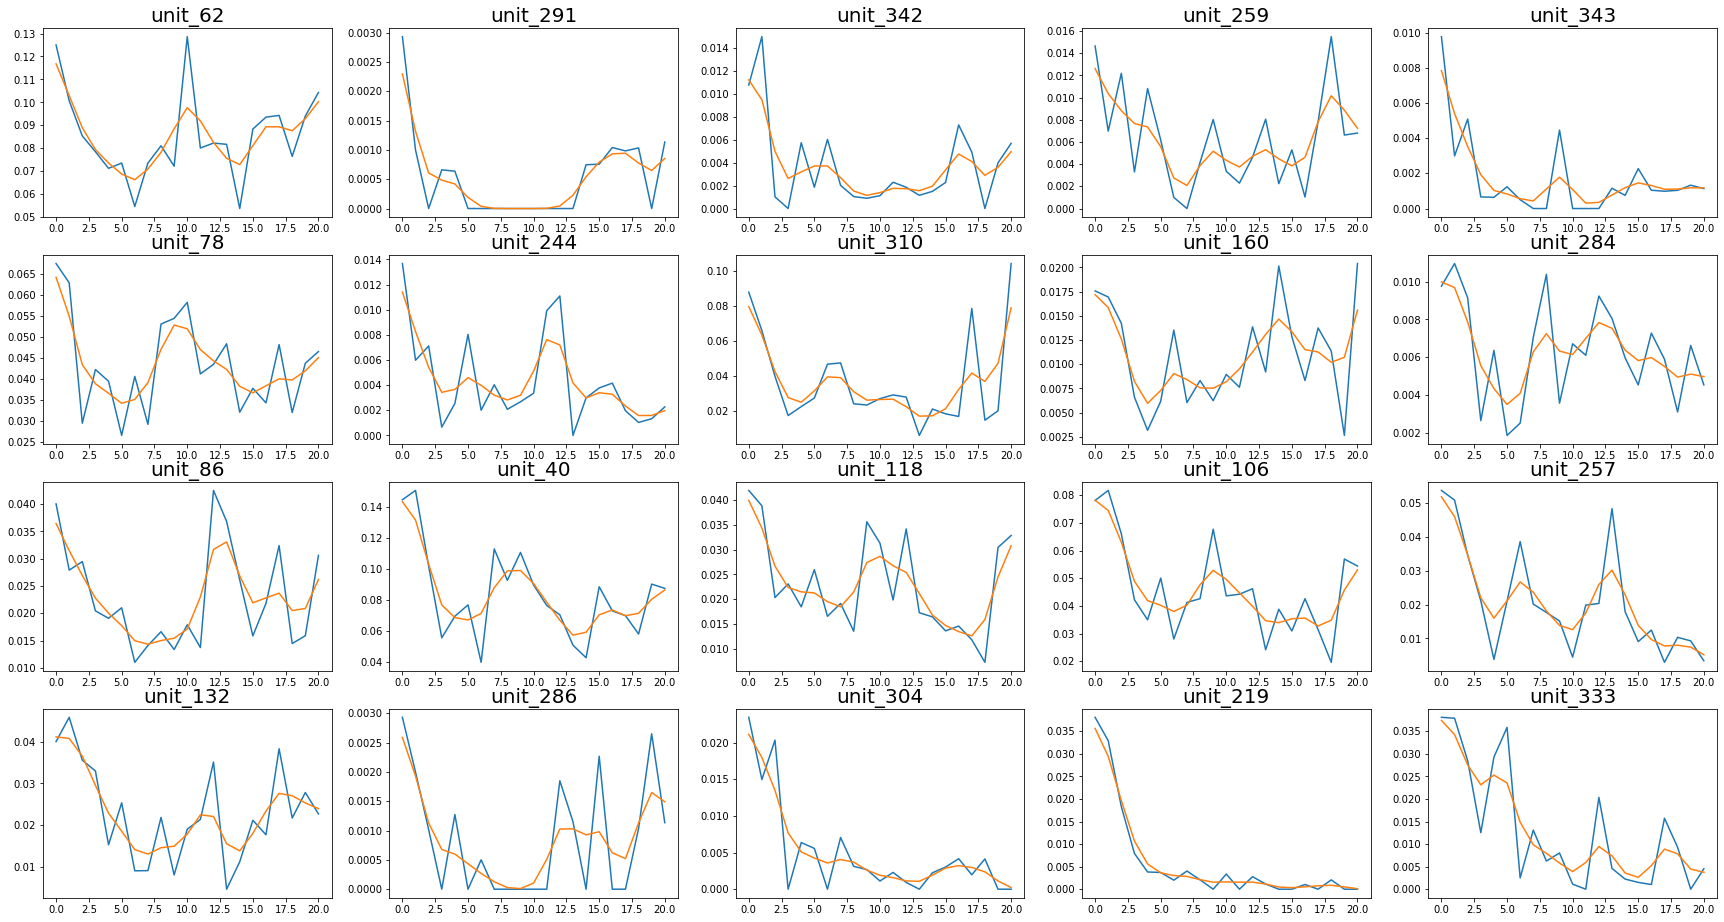

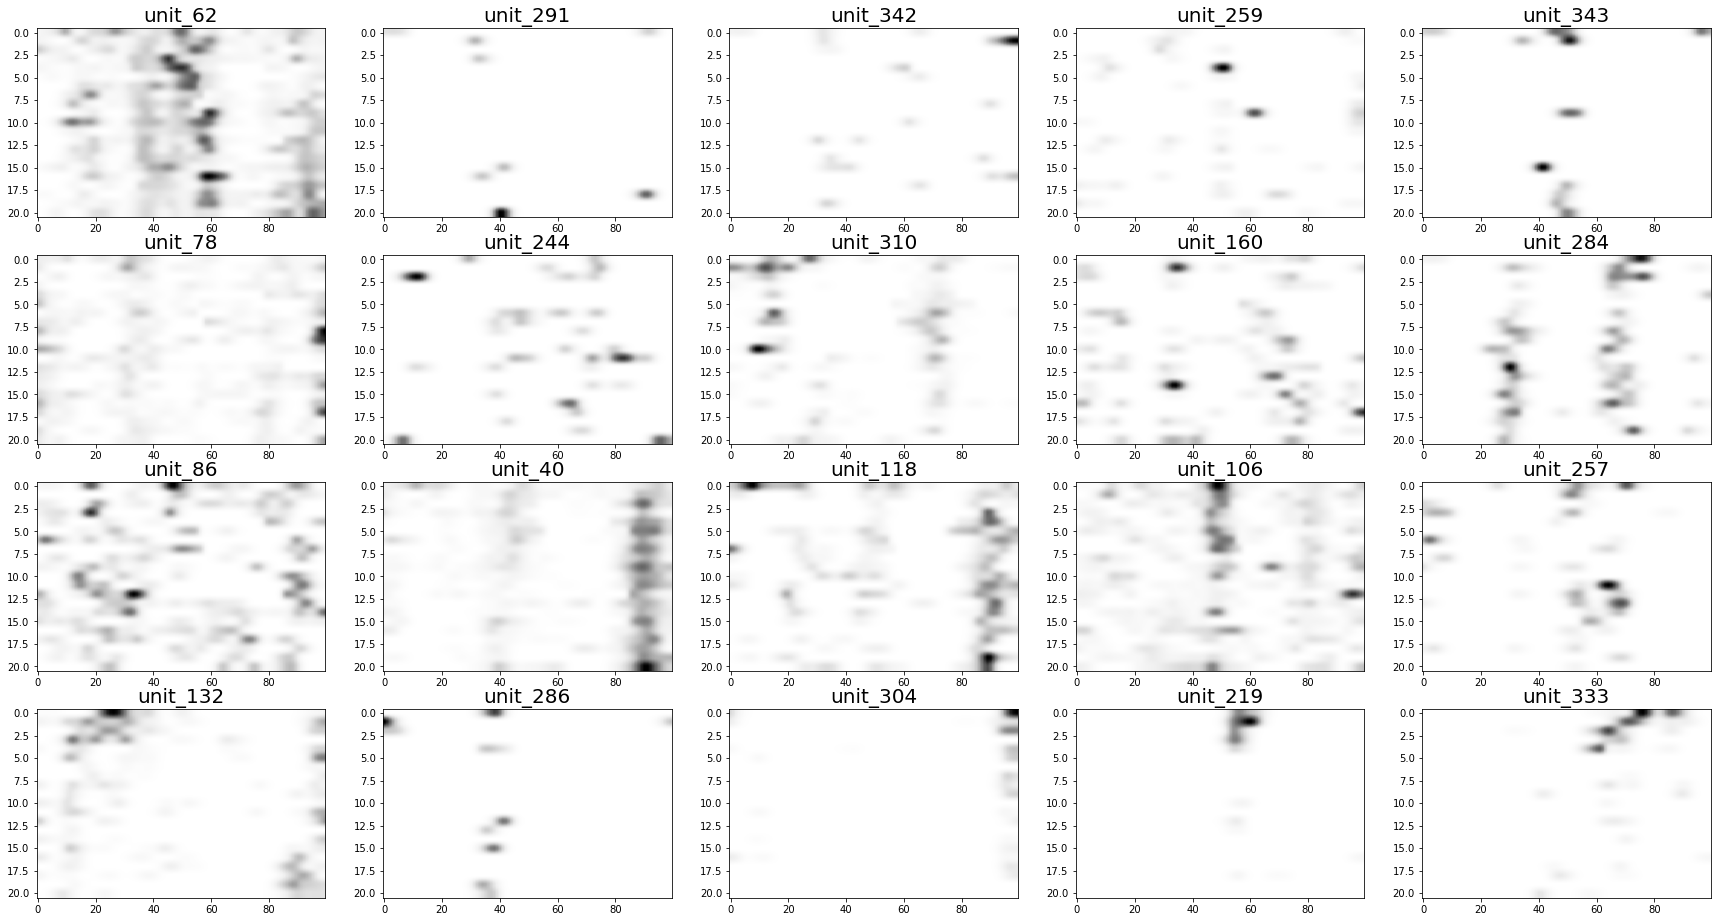

In [17]:
k='0'
fac = 0
fac_mask = factor_assignment_d[k]==fac
# fac_thresh=0.5
# sample_inds_within_W_sorted = np.nonzero(W_normed_rowsum[:,fac]>fac_thresh)[0]
sample_inds_within_W_sorted = W_inds_d[k][fac_mask][-20:]

fig,axs=nmfp.plot_example_fr_across_trials(fr_to_be_nmfed[k],sample_inds_within_W_sorted,non_na_original_ind_joint,pyr_uid)

fig,axs=nmfp.plot_example_rate_maps_across_trials(fr_map_trial[int(k)],sample_inds_within_W_sorted,non_na_original_ind_joint,pyr_uid)

(<Figure size 1296x576 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'0'}, xlabel='position', ylabel='neurons'>,
         <AxesSubplot:title={'center':'1'}, xlabel='position', ylabel='neurons'>,
         <AxesSubplot:title={'center':'2'}, xlabel='position', ylabel='neurons'>],
        [<AxesSubplot:title={'center':'3'}, xlabel='position', ylabel='neurons'>,
         <AxesSubplot:title={'center':'4'}, xlabel='position', ylabel='neurons'>,
         <AxesSubplot:title={'center':'all'}, xlabel='position', ylabel='neurons'>]],
       dtype=object))

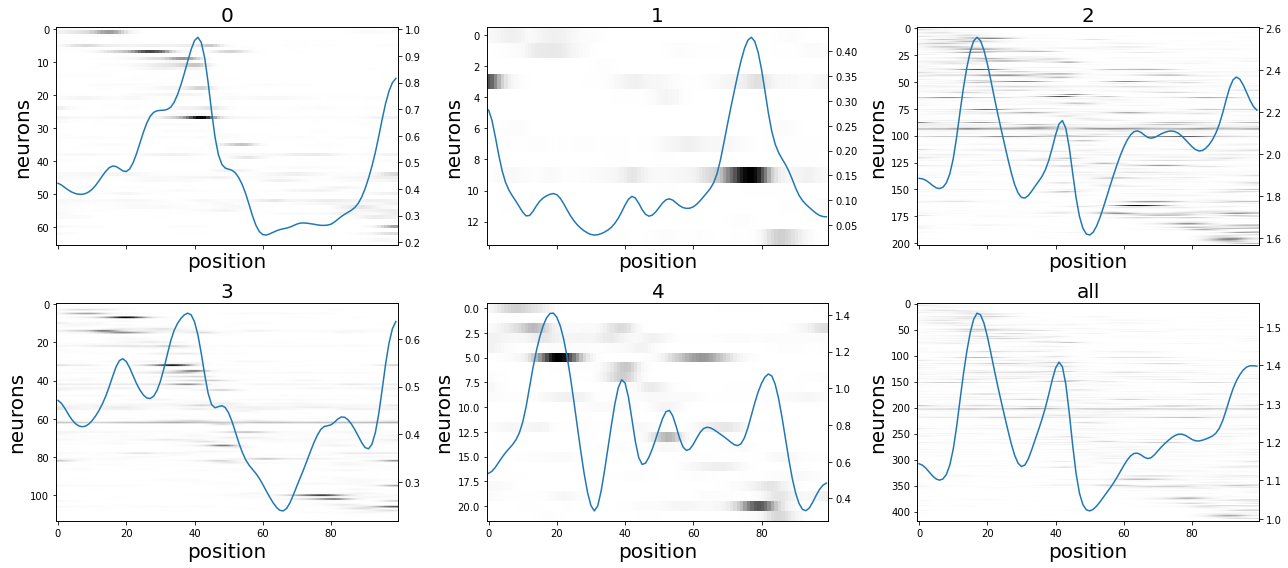

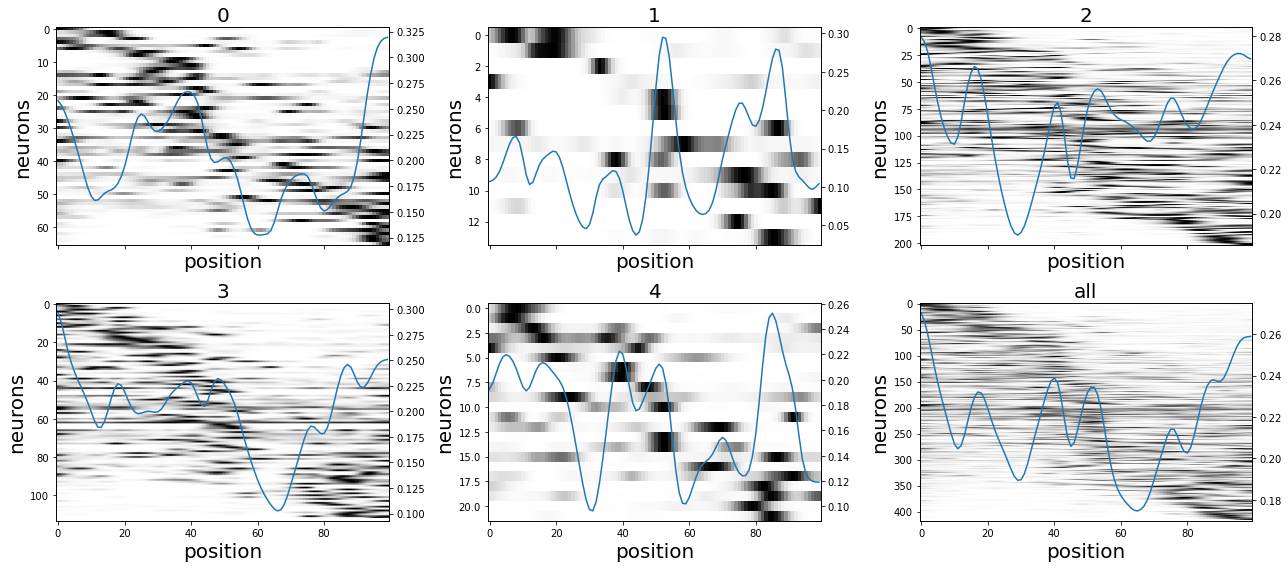

In [184]:
# trial averaged rate maps within one factor
reload(nmfp)
reload(na)
k = '1'
sort_by_com = True
sample_inds_within_W_sorted_l = na.get_clusters_from_factor_assignment(W_inds_d[k],factor_assignment_d[k])
nmfp.plot_ratemap_distribution_within_clusters(fr_map_avg[int(k)],sample_inds_within_W_sorted_l,non_na_original_ind_joint,cell_cols_pyr,normalize=False,sort_by_com=sort_by_com,fig=None,axs=None)
nmfp.plot_ratemap_distribution_within_clusters(fr_map_avg[int(k)],sample_inds_within_W_sorted_l,non_na_original_ind_joint,cell_cols_pyr,normalize=True,sort_by_com=sort_by_com,fig=None,axs=None)


# low speed

In [461]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [18]:
# fr_filtered_lowspeed = copy.copy(fr.query("(speed<=0.5)"))
fr_filtered_lowspeed = copy.copy(fr.query("(speed<=2)"))
# fr_filtered[cell_cols_pyr] = fr_filtered[cell_cols_pyr] / dt
fr_mean_trial_type = fr_filtered_lowspeed.groupby(['visitedArm','trial']).mean()[cell_cols_pyr]
fr_mean_all = fr_filtered.groupby('trial').mean()[cell_cols_pyr]

fr_to_be_nmfed_lowspeed = {'0':fr_mean_trial_type.loc[0],'1':fr_mean_trial_type.loc[1],'both':fr_mean_all}

n_compo = 4
model_d_st, W_sorted_d_st,W_inds_d_st, factor_assignment_d_st, H_sorted_d_st, X_sorted_d_st, X_recon_sorted_d_st,pyr_mask_joint_st,non_na_original_ind_joint_st=na.nmf_multiple_fr_df_once(fr_to_be_nmfed_lowspeed,n_compo)



/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:51: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant


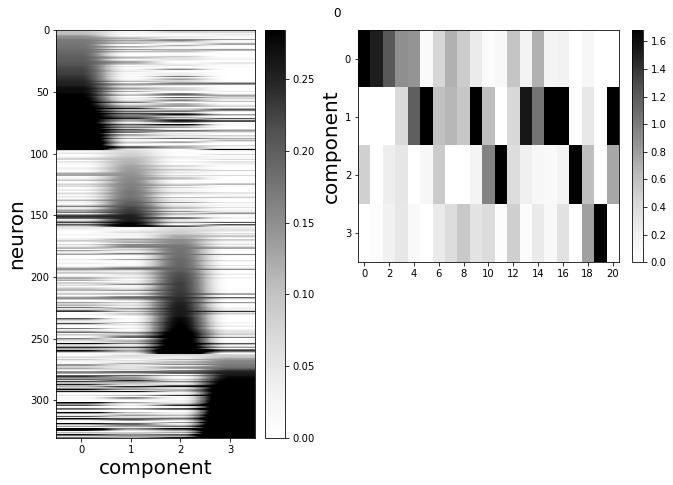

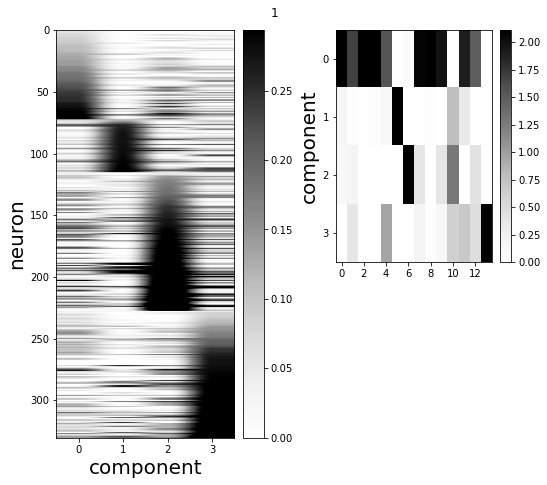

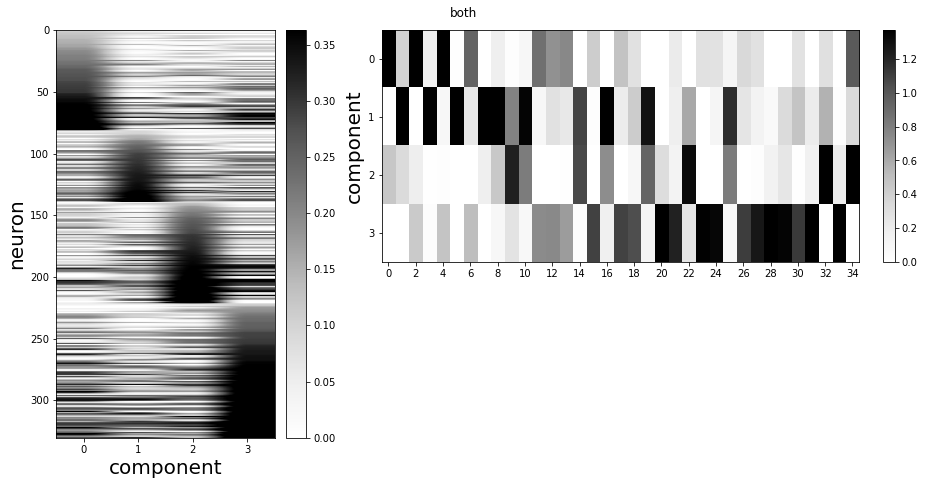

In [19]:
reload(nmfp)
for data_key in W_sorted_d.keys():
    fig,axd=nmfp.plot_wh(W_sorted_d_st[data_key],H_sorted_d_st[data_key])
    fig.suptitle(data_key)

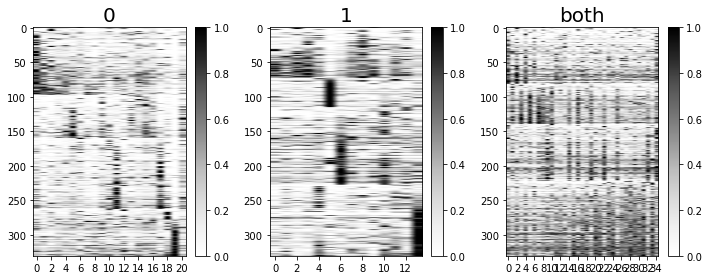

In [20]:
# speed thresh 2
fig,axs=plt.subplots(1,3,figsize=(10,4))
for ii,k in enumerate(X_sorted_d_st.keys()):
    fig,ax=nmfp.plot_X_sorted(X_sorted_d_st[k],fig=fig,ax=axs[ii])
    ax.set_title(k)
plt.tight_layout()

In [499]:
trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}

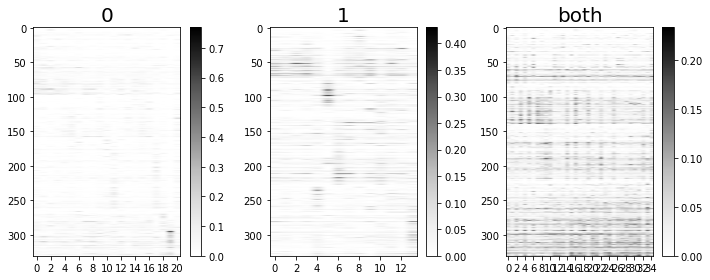

In [22]:
# stationary sorting, not normalized, speed thresh 2
fig,axs=plt.subplots(1,3,figsize=(10,4))
for ii,k in enumerate(fr_to_be_nmfed_lowspeed.keys()):
    X = fr_to_be_nmfed_lowspeed[k][cell_cols_pyr].values.T
    fig,ax=nmfp.plot_X_sorted(X[pyr_mask_joint_st][W_inds_d_st[k]],fig=fig,ax=axs[ii])
    ax.set_title(k)
plt.tight_layout()

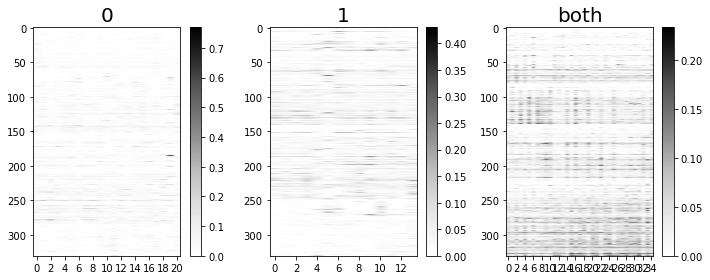

In [27]:
# sorting from running
fig,axs=plt.subplots(1,3,figsize=(10,4))
for ii,k in enumerate(fr_to_be_nmfed_lowspeed.keys()):
    X = fr_to_be_nmfed_lowspeed[k][cell_cols_pyr].values.T
    fig,ax=nmfp.plot_X_sorted(X[pyr_mask_joint][W_inds_d[k]],fig=fig,ax=axs[ii])
    ax.set_title(k)
plt.tight_layout()

In [28]:
reload(nmfp)

<module 'nmf_plot' from '/mnt/home/szheng/projects/nmf_analysis/nmf_plot.py'>

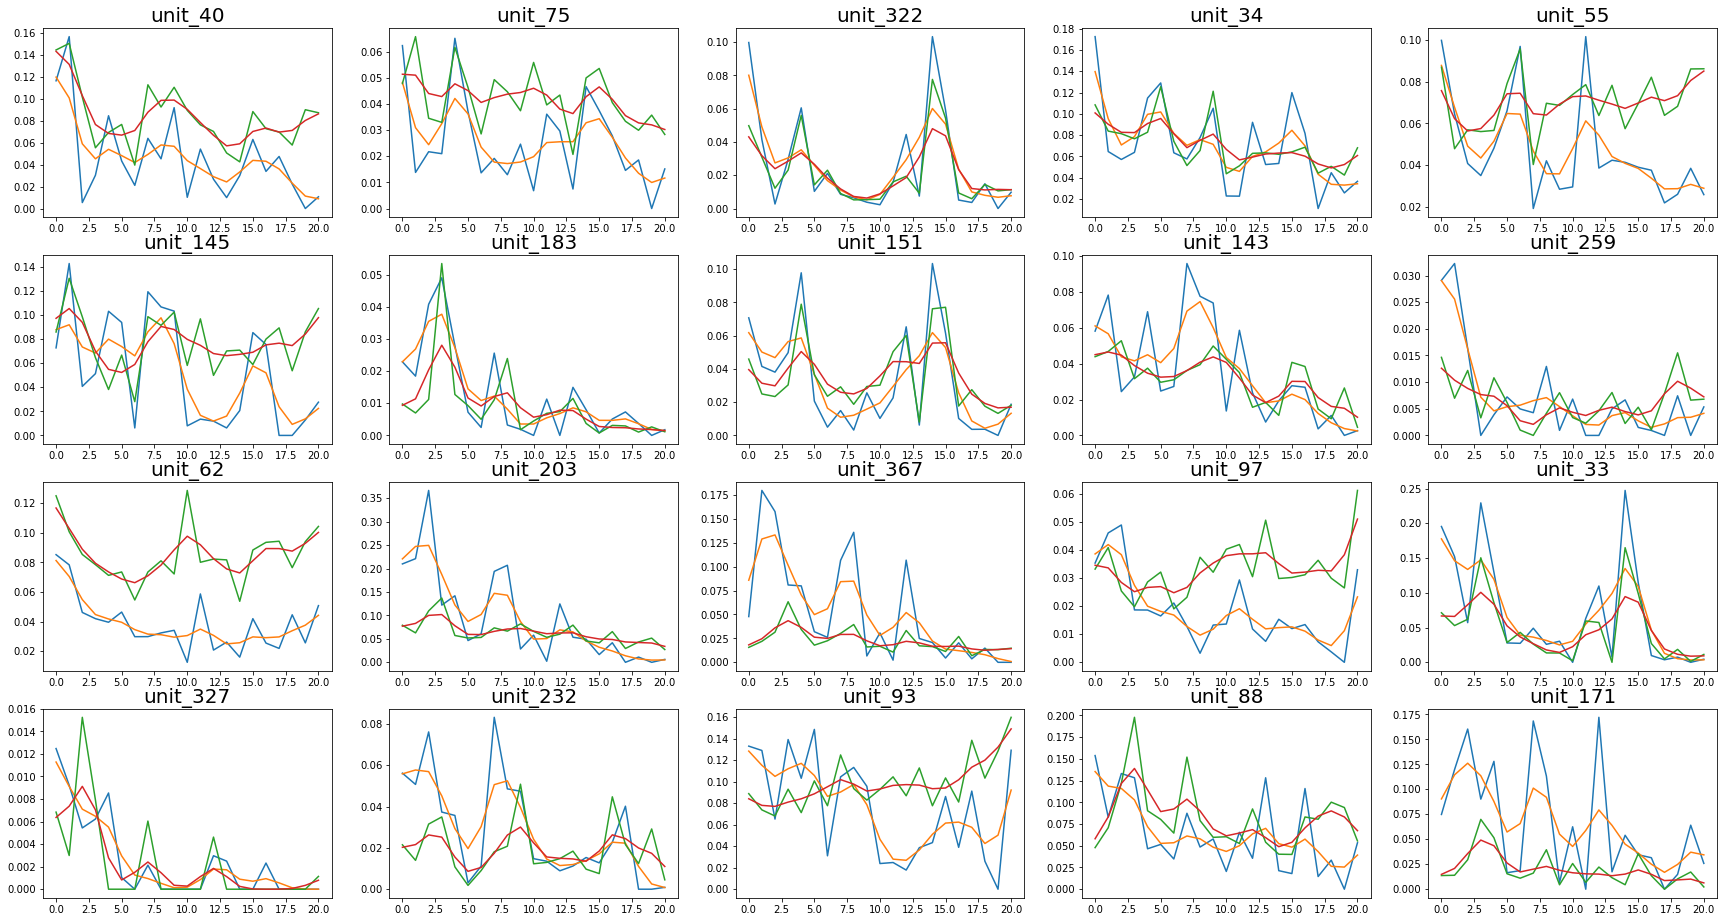

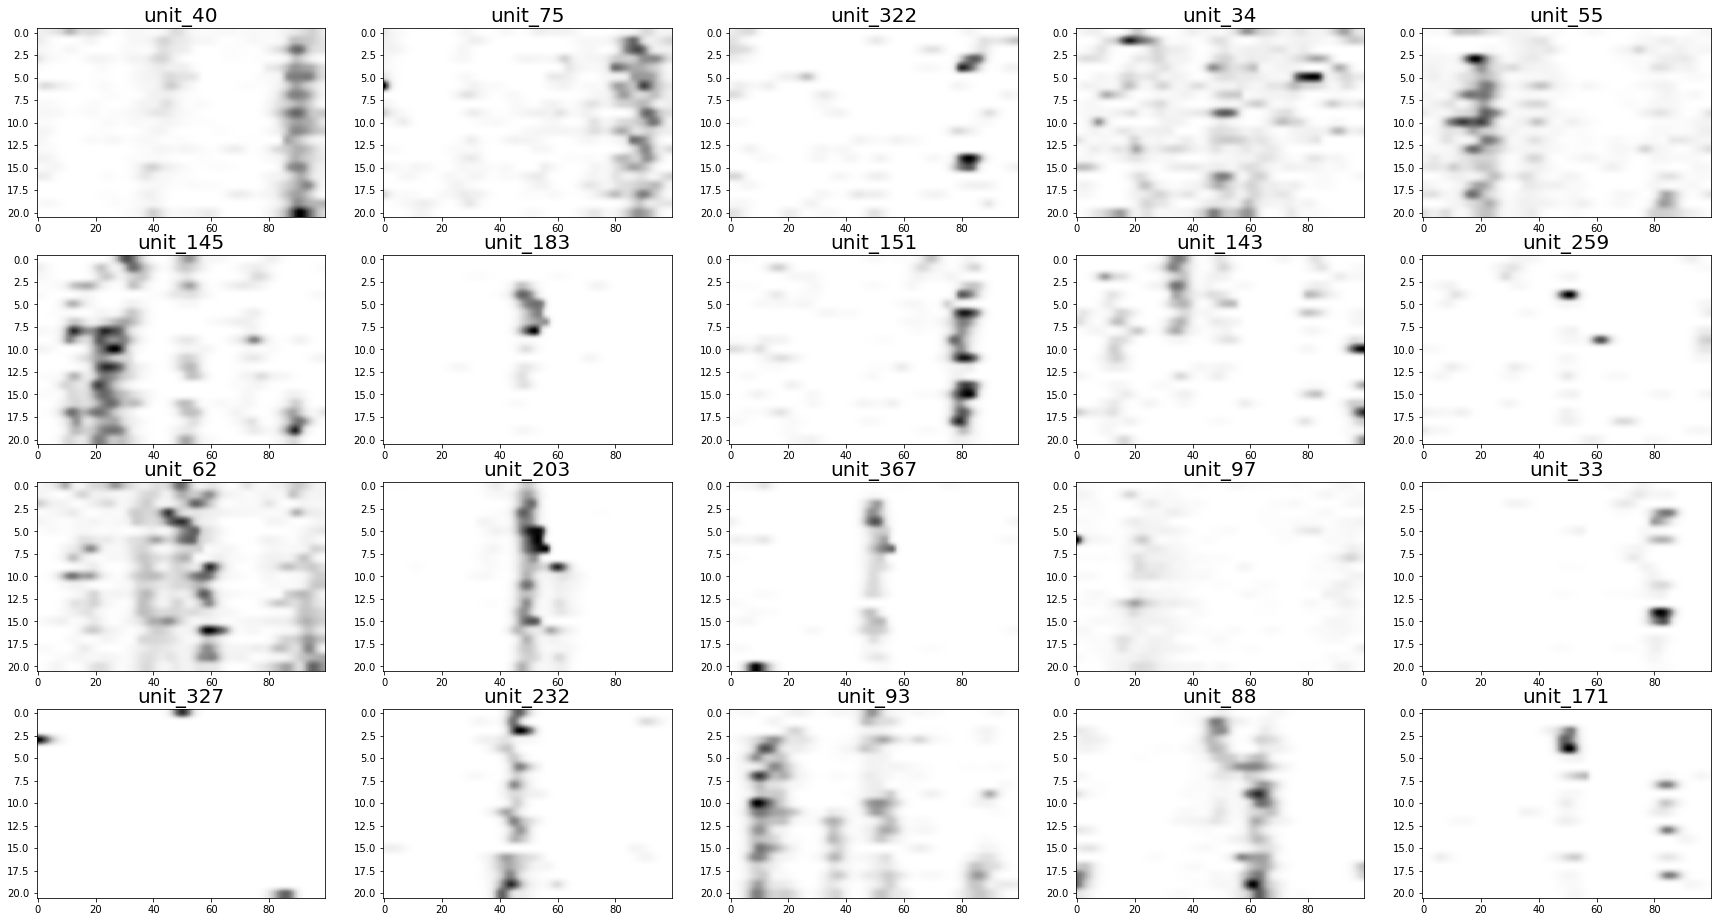

In [59]:
k='0'
fac = 0
fac_mask = factor_assignment_d_st[k]==fac
# fac_thresh=0.5
# sample_inds_within_W_sorted = np.nonzero(W_normed_rowsum[:,fac]>fac_thresh)[0]
sample_inds_within_W_sorted = W_inds_d_st[k][fac_mask][-20:]

fig,axs=nmfp.plot_example_fr_across_trials(fr_to_be_nmfed_lowspeed[k],sample_inds_within_W_sorted,non_na_original_ind_joint_st,pyr_uid)

fig,axs=nmfp.plot_example_fr_across_trials(fr_to_be_nmfed[k],sample_inds_within_W_sorted,non_na_original_ind_joint,pyr_uid,fig=fig,axs=axs)

fig,axs=nmfp.plot_example_rate_maps_across_trials(fr_map_trial[int(k)],sample_inds_within_W_sorted,non_na_original_ind_joint_st,pyr_uid)

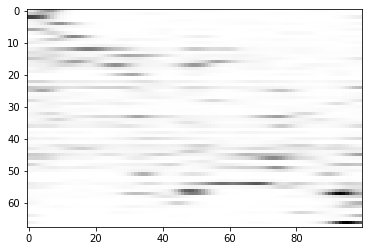

In [57]:
# trial averaged rate maps within one factor
fac = 3
fac_mask = factor_assignment_d_st[k]==fac
sample_inds_within_W_sorted = W_inds_d_st[k][fac_mask][:]
cell_cols_pyr[non_na_original_ind_joint_st][sample_inds_within_W_sorted]
frmap_toplot = fr_map_avg[int(k)].loc[cell_cols_pyr[non_na_original_ind_joint_st][sample_inds_within_W_sorted]]
sort_by_com=na.get_com(frmap_toplot,axis=1).argsort()
plt.imshow(frmap_toplot.iloc[sort_by_com],aspect='auto')

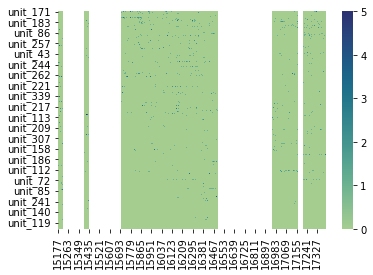

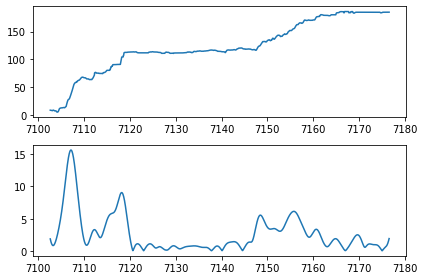

In [676]:
fr_filtered_lowspeed = fr.query("(speed<=2)&(visitedArm==0)")

fr_filtered_lowspeed_onetrial=fr_filtered_lowspeed.query('trial==11')
lowspeedslice=np.arange(fr_filtered_lowspeed_onetrial.index.min(),fr_filtered_lowspeed_onetrial.index.max()+1)
fr_lowspeedslice=fr.loc[lowspeedslice]
# ma =fr_lowspeedslice['speed'] < 0.5
ma =fr_lowspeedslice['speed'] > 2
df_just_neurons=fr_lowspeedslice[cell_cols_pyr].T

order = W_inds_d_st[kk][np.flip(np.argsort(W_sorted_d_st[kk][:,0]))]
sns.heatmap(df_just_neurons.iloc[order],mask=ma,cmap='crest')
fig,axs=plt.subplots(2,1)
axs[0].plot(fr_lowspeedslice['times'],fr_lowspeedslice['lin'])
axs[1].plot(fr_lowspeedslice['times'],fr_lowspeedslice['speed'])
plt.tight_layout()

<AxesSubplot:>

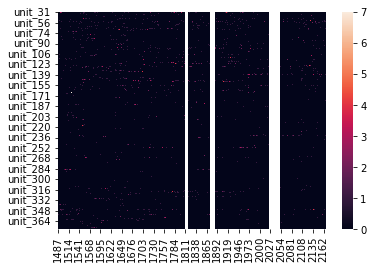

In [619]:
fr_filtered_lowspeed_onetrial=fr_filtered_lowspeed.query('trial==1')
lowspeedslice=np.arange(fr_filtered_lowspeed_onetrial.index.min(),fr_filtered_lowspeed_onetrial.index.max()+1)
fr_lowspeedslice=fr.loc[lowspeedslice]
ma =fr_lowspeedslice['speed'] < 0.5
df_just_neurons=fr_lowspeedslice[cell_cols_pyr].T
sns.heatmap(df_just_neurons,mask=ma)


In [682]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [683]:
# simple question: correlation between fr during running and stationary, for each neuron, across trials
speed_thresh = 2.5
speed_mask = fr['speed'] > speed_thresh
speed_mask_slow = np.logical_not(speed_mask)
fr_d_fast = na.get_mean_fr_by_trial_types(fr,cell_cols_pyr,speed_mask)
fr_d_slow = na.get_mean_fr_by_trial_types(fr,cell_cols_pyr,speed_mask_slow)

<AxesSubplot:>

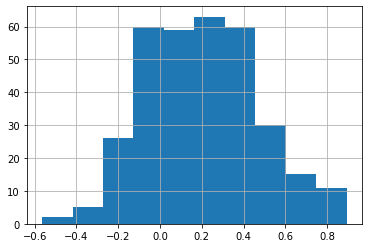

In [688]:
fr_d_fast['0'].corrwith(fr_d_slow['0']).hist()

<AxesSubplot:>

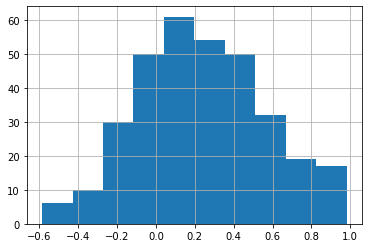

In [689]:
fr_d_fast['1'].corrwith(fr_d_slow['1']).hist()

In [486]:
##### CV. Can't figure out why the test_error is always the smallest with the least number of components
# cv_ratio = 0.4
# n_compo = 1
# X = X_to_be_nmfed['0'][pyr_mask]
# train_mask = np.random.rand(*(X.shape)) > cv_ratio
# test_err, W, H, Z, recon, i, converged, train_err_l = na.masked_nmf(X,n_compo,train_mask,max_iters=100)
# print(test_err)

12.822809353921164


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Increase it to improve convergence.
  warnings.warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 800 reached. Inc